In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
import seaborn as sns

/home/seb/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**The US data situation is complicated.** 

- CDC makes available weekly data on Covid-19 deaths and all-cause mortality for a few weeks in 2020 here: https://www.cdc.gov/nchs/nvss/vsrr/COVID19/index.htm. These data suffer from significant reporting delay. 

- CDC also makes available (through one of their systems called "Fluview") weekly data on all-cause mortality going back to 2013. https://gis.cdc.gov/grasp/fluview/mortality.html. These data have varying degrees of completeness depending on date, with the most recent data showing more incompleteness. The CDC data are also disaggregated by State (again showing percentage completeness) and even give figures for NYC, which is why we can do our analysis there. NYC has the advantage of having more complete data for more recent times in 2020. To make sense of the dates in the CDC data (which are reported by "season"), we also use the data here: https://www.cdc.gov/flu/weekly/#S2 $\to$ Pneumonia and Influenza (P&I) Mortality Surveillance $\to$ View Chart Data. 

- Finally, NYC data on Covid-19 fatalities are reported here: https://www1.nyc.gov/site/doh/covid/covid-19-data.page

**IMPORTANT** Currently, the national data still suffer from reporting delays too severe to run our analysis. For New York City, the most severely affected area, we can run our analysis until week 13 (ending March 28th) as the CDC reports 100% complete data there.

# 1) Data wrangling and exploration

## 1.1) Getting the national fluview data and lining up the dates

In [2]:
fluview_seasonal_national = pd.read_csv('./data/National_Custom_Data.csv')[['SEASON', 'WEEK', 'TOTAL DEATHS', 'PERCENT COMPLETE']]

In [3]:
fluview_seasonal_national['y1'] = fluview_seasonal_national['SEASON'].str[:4]
fluview_seasonal_national['y2'] = '20' + fluview_seasonal_national['SEASON'].str[5:]
fluview_seasonal_national['year'] = '0'
fluview_seasonal_national.loc[fluview_seasonal_national.WEEK >= 40, 'year'] = fluview_seasonal_national.y1
fluview_seasonal_national.loc[fluview_seasonal_national.WEEK < 40, 'year'] = fluview_seasonal_national.y2
fluview_seasonal_national['complete'] = fluview_seasonal_national['PERCENT COMPLETE'].apply(lambda x: re.search('([0-9]+.*?[0-9])', x).group(1))
fluview_seasonal_national['total_deaths'] = fluview_seasonal_national['TOTAL DEATHS'].apply(lambda x: re.sub(',', '', x)).astype('int')
fluview_seasonal_national = fluview_seasonal_national[['year', 'WEEK', 'complete', 'total_deaths']]
fluview_seasonal_national.columns = ['year', 'week', 'complete', 'total_deaths_fv']
fluview_seasonal_national = fluview_seasonal_national.sort_values(['year', 'week']).reset_index(drop=True).copy(deep=True)
fluview_seasonal_national['year'] = fluview_seasonal_national['year'].astype('int')

## 1.2 Checking that date-lineup was done correctly

In [4]:
fluview_annual_national = pd.read_csv('./data/NCHSData14.csv')

In [5]:
fluview_annual_national = fluview_annual_national[['Year', 'Week', 'All Deaths']]
fluview_annual_national.columns = ['year', 'week', 'total_check']

In [6]:
fluview_national = pd.merge(fluview_seasonal_national, fluview_annual_national, on=['year', 'week'], how='outer', indicator=True)
print(fluview_national._merge.value_counts())
del fluview_national['_merge']

both          339
right_only      0
left_only       0
Name: _merge, dtype: int64


In [7]:
fluview_national[fluview_national.total_deaths_fv != fluview_national.total_check]

,year,week,complete,total_deaths_fv,total_check


In [8]:
fluview_national = fluview_national[['year', 'week', 'complete', 'total_deaths_fv']].reset_index(drop=True).copy(deep=True)

## 1.3 Adding the latest national figures on total and Covid deaths

In [9]:
latest_national = pd.read_csv('./data/Provisional_Death_Counts_for_Coronavirus_Disease__COVID-19_.csv')

How to line up the weeks with the dates? Here: https://www.cdc.gov/flu/weekly/#S2, the CDC says that "[...] 10.0% of the deaths occurring during the **week ending March 28, 2020 (week 13)** were due to P&I". So we can line up "week 13" in the fluview data with the week ending March 28 in the latest national data.

In [10]:
latest_national = latest_national.iloc[1:,:]
latest_national = latest_national[latest_national.Group == 'By week']
latest_national = latest_national[['Indicator', 'All COVID-19 Deaths (U07.1)', 'Deaths from All Causes']]
latest_national['week'] = np.arange(5,16)
latest_national.columns = ['date', 'covid_deaths', 'total_deaths_latest', 'week']
latest_national

,date,covid_deaths,total_deaths_latest,week
1,2/1/2020,0,"56,557",5
2,2/8/2020,0,"57,067",6
3,2/15/2020,0,"56,079",7
4,2/22/2020,0,"55,605",8
5,2/29/2020,5,"54,900",9
6,3/7/2020,19,"54,222",10
7,3/14/2020,44,"52,187",11
8,3/21/2020,447,"51,428",12
9,3/28/2020,"2,205","51,602",13
10,4/4/2020,"4,462","46,917",14


In [11]:
latest_national['year'] = 2020
latest_national = latest_national[['date', 'year', 'week', 'total_deaths_latest', 'covid_deaths']].copy(deep=True)
latest_national['total_deaths_latest'] = latest_national['total_deaths_latest'].apply(lambda x: re.sub(',', '', x)).astype('int')
latest_national['covid_deaths'] = latest_national['covid_deaths'].apply(lambda x: re.sub(',', '', x)).astype('int')

merging with the fluview data

In [12]:
nat = pd.merge(fluview_national, latest_national, on=['year', 'week'], how='outer')

In [13]:
nat.tail(11)

,year,week,complete,total_deaths_fv,date,total_deaths_latest,covid_deaths
330,2020,5,100,56231.0,2/1/2020,56557.0,0.0
331,2020,6,100,56586.0,2/8/2020,57067.0,0.0
332,2020,7,100,55109.0,2/15/2020,56079.0,0.0
333,2020,8,100,54650.0,2/22/2020,55605.0,0.0
334,2020,9,100,54268.0,2/29/2020,54900.0,5.0
335,2020,10,100,53463.0,3/7/2020,54222.0,19.0
336,2020,11,100,50785.0,3/14/2020,52187.0,44.0
337,2020,12,100,48488.0,3/21/2020,51428.0,447.0
338,2020,13,93.3,44402.0,3/28/2020,51602.0,2205.0
339,2020,14,NaN,NaN,4/4/2020,46917.0,4462.0


In [14]:
nat['total_deaths'] = nat.total_deaths_fv
nat.loc[~pd.isnull(nat.total_deaths_latest), 'total_deaths'] = nat.total_deaths_latest
nat = nat[['date', 'year', 'week', 'total_deaths', 'covid_deaths']].copy(deep=True)

## 1.4 Illustrating that reporting delays are currently too severe to say anything at the national level

In [15]:
df = nat[~pd.isnull(nat.date)].reset_index(drop=True).copy(deep=True)
df['y'] = '2020'
df['m'] = '0' + df.date.str[:1]
df['d'] = ('0' + df.date.apply(lambda x: re.search('[0-9]/([0-9]+)/', x).group(1))).str[-2:]
df['date'] = df.y + '-' + df.m + '-' + df.d
df['date']  =  pd.to_datetime(df['date'] , format='%Y%m%d', errors='ignore')
df = df[['date', 'total_deaths', 'covid_deaths']]
df.index = df.date
del df['date']

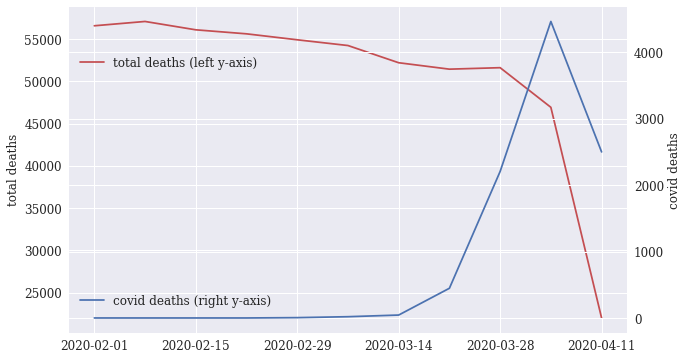

In [16]:
palette = sns.color_palette()

fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
ax1.plot(df.index, df.total_deaths, label='total deaths (left y-axis)', color=palette[2])
ax2.plot(df.index, df.covid_deaths, label='covid deaths (right y-axis)', color=palette[0])

ax1.set_xticks(df.index[[0, 2, 4, 6, 8, 10]], )
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

ax1.set_ylabel('total deaths', size=12)
ax2.set_ylabel('covid deaths', size=12)

ax1.legend(loc='upper left', fontsize=12, bbox_to_anchor=(0, 0.1, 0.1, 0.78))
ax2.legend(loc='upper left', fontsize=12, bbox_to_anchor=(0, 0.1, 0.1, 0.05))

plt.show()

This graph shows that, in 2020, just as the number of reported Covid-19 deaths starts to rise to become detectable in the all-cause mortality data, the total number of deaths plummets. Hence it is too early to analyse the US as a whole. A similar point can be made by comparing the total number of death per week for 2020 to the previous weeks. 

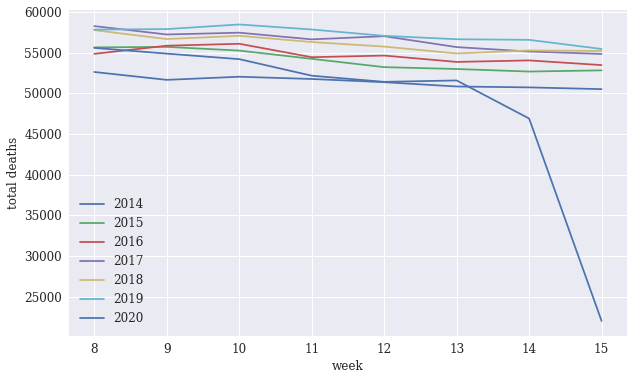

In [17]:
df = nat[['year', 'week', 'total_deaths']].copy(deep=True)
for yr in range(2014, 2021):
    dfy = df[df.year == yr][['week', 'total_deaths']].reset_index(drop=True).copy(deep=True)
    dfy.columns = ['week', '{}'.format(yr)]
    if yr == 2014:
        dfall = dfy
    else:
        dfall = pd.merge(dfall, dfy, on=['week'], how='outer')
df = dfall[(~pd.isnull(dfall['2020'])) & (dfall.week >= 8)].sort_values(['week']).reset_index(drop=True).copy(deep=True)
df.index = df.week
del df['week']
df.plot(figsize=(10, 6))
plt.ylabel('total deaths', size=12)
plt.xlabel('week', size=12)
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## 1.5 Getting the fluview data for NYC

In [18]:
fluview_nyc = pd.read_csv('./data/State_Custom_Data.csv')[['SUB AREA', 'SEASON', 'WEEK', 'TOTAL DEATHS', 'PERCENT COMPLETE']]

In [19]:
fluview_nyc = fluview_nyc[fluview_nyc['SUB AREA'] == 'New York City']\
              [['SEASON', 'WEEK', 'TOTAL DEATHS', 'PERCENT COMPLETE']]\
              .reset_index(drop=True).copy(deep=True)

fluview_nyc['y1'] = fluview_nyc['SEASON'].str[:4]
fluview_nyc['y2'] = '20' + fluview_nyc['SEASON'].str[5:]
fluview_nyc['year'] = '0'
fluview_nyc.loc[fluview_nyc.WEEK >= 40, 'year'] = fluview_nyc.y1
fluview_nyc.loc[fluview_nyc.WEEK < 40, 'year'] = fluview_nyc.y2
fluview_nyc['complete'] = fluview_nyc['PERCENT COMPLETE'].apply(lambda x: re.search('([0-9]+.*?[0-9])', x).group(1))
fluview_nyc['total_deaths'] = fluview_nyc['TOTAL DEATHS'].apply(lambda x: re.sub(',', '', x)).astype('int')
fluview_nyc = fluview_nyc[['year', 'WEEK', 'complete', 'total_deaths']]
fluview_nyc.columns = ['year', 'week', 'complete', 'total_deaths']
fluview_nyc = fluview_nyc.sort_values(['year', 'week']).reset_index(drop=True).copy(deep=True)
fluview_nyc['year'] = fluview_nyc['year'].astype('int')

In [20]:
fluview_nyc

,year,week,complete,total_deaths
0,2013,1,85.7,873
1,2013,2,100,1292
2,2013,3,100,1214
3,2013,4,100,1252
4,2013,5,100,1231
...,...,...,...,...
373,2020,9,100,1092
374,2020,10,100,1078
375,2020,11,100,1097
376,2020,12,100,1317


Note that the data for week 13 are 100% complete. So we can use these data to run our analysis.

In [21]:
df = fluview_nyc[['year', 'week', 'total_deaths']].copy(deep=True)
df.index = [fluview_nyc.week, fluview_nyc.year]
df = df.drop(['year', 'week'], axis=1)
df = df.unstack()
df.columns = df.columns.droplevel()
df.reset_index(inplace=True)
df.columns = ['week'] + ['{}'.format(yr) for yr in range(2013, 2021)]
df = df[['week'] + ['{}'.format(yr) for yr in range(2015, 2021)]]
df = df[~pd.isnull(df['2020'])]

First covid death in NYC is week 11 $\to$ discard all dates prior to week 10

In [22]:
df = df[df.week >= 10].reset_index(drop=True).copy(deep=True)

computing cumulative sums

In [23]:
for yr in range(2015, 2021):
    df['cs_{}'.format(yr)] = df['{}'.format(yr)].cumsum()
    del df['{}'.format(yr)]

computing growth rates 2015-2019

In [24]:
for yr in range(2015, 2020):
    df['gr_{}'.format(yr)] = df['cs_{}'.format(yr)] / df['cs_{}'.format(yr)].shift(1)
    del df['cs_{}'.format(yr)]

computing average of weekly growth rates 15-19

In [25]:
df['weekly_growth'] = df.loc[:,['gr_{}'.format(yr) for yr in range(2015,2020)]].mean(axis=1)
df = df.drop(['gr_{}'.format(yr) for yr in range(2015,2020)], axis=1)

extrapolating forward

In [26]:
df['counterfactual'] = 0
df.loc[0,'counterfactual'] = df.loc[df.week==10,'cs_2020'].values[0]

In [27]:
for i in range(1, df.shape[0]):
    df.loc[i,'counterfactual'] = df.loc[i-1,'counterfactual'] * df.loc[i,'weekly_growth']

In [28]:
df = df.drop(['weekly_growth'], axis=1)

# 2) Getting the Covid-19 data for NYC

## 2.1) Assigning to the right CDC-week

CDC has weeks ending on Saturday (e.g. week ending March 28th).

In [29]:
cal = pd.read_csv('./data/day_month_week_2020_cdc.csv')

In [30]:
official = pd.read_csv('./data/data-4SfjZ.csv')

In [31]:
official.columns = ['date', 'cases', 'hosp', 'covid_deaths']
official = official[['date', 'covid_deaths']]
official = official.fillna(0)
official['covid_deaths'] = official.covid_deaths
official['day'] = official.date.apply(lambda x: re.search('[0-9]+/([0-9]+)/', x).group(1)).astype('int')
official['month'] = official.date.apply(lambda x: re.search('([0-9]+)/[0-9]+/', x).group(1)).astype('int')
official = pd.merge(official, cal, on=['month', 'day'], how='inner')
official = official[['week', 'covid_deaths']].groupby('week').sum().reset_index(drop=False).copy(deep=True)

In [32]:
cal['dyr'] = np.arange(1,cal.shape[0]+1)
cal['maxd'] = cal[['dyr', 'week']].groupby('week').transform(max)
cal = cal[cal.dyr == cal.maxd][['day', 'month', 'week']].reset_index(drop=True).copy(deep=True)
cal['day'] = ('0' + cal.day.astype('str')).str[-2:]
cal['month'] = '0' + cal.month.astype('str')
cal['date'] = '2020-' + cal.month + '-' + cal.day
cal = cal.drop(['day', 'month'], axis=1)

In [33]:
official = pd.merge(official, cal, on='week', how='left')
official['covid_deaths'] = official.covid_deaths.cumsum()

# 3) Merging and plotting

In [34]:
df = pd.merge(df, official, on = 'week', how='left')
df['counterfactual_2020_covid'] = df.counterfactual + df.covid_deaths
del df['covid_deaths']
del df['week']
df.index = df.date
del df['date']

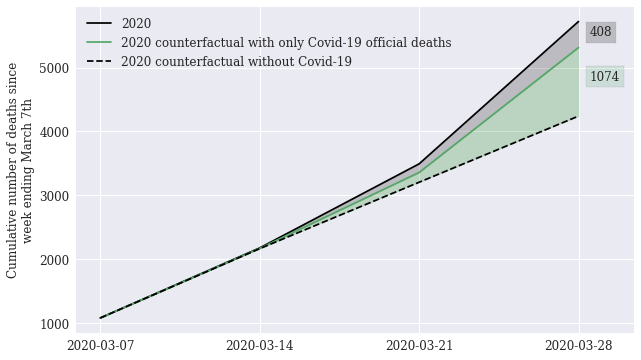

In [35]:
palette = sns.color_palette()

f = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)

ax.plot(df.index,
        df['cs_2020'],
        label='2020',
        color='black')
ax.plot(df.index,
        df['counterfactual_2020_covid'],
        label='2020 counterfactual with only Covid-19 official deaths',
        color = palette[1])
ax.plot(df.index,
        df['counterfactual'],
        label='2020 counterfactual without Covid-19',
        color='black', 
        linestyle = '--')

ax.set_xticks(df.index[[0,1,2,3]])
ax.fill_between(df.index, df['cs_2020'], df['counterfactual_2020_covid'], color='black', alpha='0.2')
ax.fill_between(df.index, df['counterfactual_2020_covid'], df['counterfactual'], color='green', alpha='0.2')

ax.set_ylabel('Cumulative number of deaths since\nweek ending March 7th',size=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='upper left',
          fontsize=12)

plot_margin = 0.2

x0, x1, y0, y1 = plt.axis()
plt.axis((x0,
          x1 + plot_margin,
          y0,
          y1))

plt.text(3.07, 4800, '{}'.format(int(round(df.iloc[-1, 2] - df.iloc[-1, 1]))),
         bbox=dict(facecolor=palette[1], alpha=0.2), size=12)


plt.text(3.07, 5500, '{}'.format(int(round(df.iloc[-1, 0] - df.iloc[-1, 2]))),
         bbox=dict(facecolor='black', alpha=0.2), size=12)

plt.show()

f.savefig('_new_york_city.pdf', bbox_inches='tight', dpi=100)

In [36]:
print('Official covid-deaths: {} = green - dashed black'.format(round(df.iloc[-1, 2] - df.iloc[-1, 1])))
print('Excess deaths: {} = solid black - dashed black'.format(round(df.iloc[-1, 0] - df.iloc[-1, 1])))
print('Unexplained excess deaths: {} = solid black - green'.format(round(df.iloc[-1, 0] - df.iloc[-1, 2])))

Official covid-deaths: 1074.0 = green - dashed black
Excess deaths: 1482.0 = solid black - dashed black
Unexplained excess deaths: 408.0 = solid black - green
